In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from glob import glob

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2


In [2]:
from obiwan.common import fits2pandas

In [3]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr3_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/decals-dr3.1-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/deep2-field*-trim.fits'))                                                               
dr3_fns,dp2_fns

(['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits'],
 ['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits'])

In [4]:
def stack_tables(fns):
    cat=[]
    assert(len(fns) > 0)
    for fn in fns:
        assert(os.path.exists(fn))
        print('Stacking %s' % fn)
        cat.append( fits_table(fn) )
    return merge_tables(cat, columns='fillzero')

dr3= stack_tables(dr3_fns)
dp2= stack_tables(dp2_fns)
len(dr3),len(dp2)

Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits
Converted source from |S12 to <U12
Converted vis_morph from |S1 to <U1
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits
Converted source from |S12 to <U12
Converted vis_morph from |S1 to <U1
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits
Converted source from |S12 to <U12
Converted vis_morph from |S1 to <U1


(28284, 28284)

In [5]:
dr3.get_columns(), dp2.get_columns()

(['brickid',
  'brickname',
  'objid',
  'type',
  'ra',
  'ra_ivar',
  'dec',
  'dec_ivar',
  'decam_flux',
  'decam_flux_ivar',
  'decam_mw_transmission',
  'decam_nobs',
  'decam_rchi2',
  'decam_psfsize',
  'decam_fracflux',
  'decam_fracmasked',
  'decam_fracin',
  'decam_depth',
  'decam_galdepth',
  'out_of_bounds',
  'decam_anymask',
  'decam_allmask',
  'wise_flux',
  'wise_flux_ivar',
  'wise_mw_transmission',
  'wise_nobs',
  'wise_fracflux',
  'wise_rchi2',
  'dchisq',
  'fracdev',
  'tycho2inblob',
  'shapedev_r',
  'shapedev_r_ivar',
  'shapedev_e1',
  'shapedev_e1_ivar',
  'shapedev_e2',
  'shapedev_e2_ivar',
  'shapeexp_r',
  'shapeexp_r_ivar',
  'shapeexp_e1',
  'shapeexp_e1_ivar',
  'shapeexp_e2',
  'shapeexp_e2_ivar',
  'ebv'],
 ['field',
  'subfield',
  'objno',
  'ra',
  'dec',
  'b',
  'r',
  'i',
  'berr',
  'rerr',
  'ierr',
  'pgal',
  'rg',
  'badflag',
  'zhelio',
  'zhelio_err',
  'zquality',
  'sfd_ebv',
  'source',
  'mask_weight',
  'obj_weight',
  'selec

In [6]:
grz_gt0= (np.all(dr3.decam_flux[:,[1,2,4]] > 0,axis=1) &
          np.all(dr3.decam_flux_ivar[:,[1,2,4]] > 0,axis=1))
len(dr3[grz_gt0])

27433

In [7]:
keep= ((dp2.zhelio >= 0.8) &
       (dp2.zhelio <= 1.4) &
       (dp2.oii_3727 >= 0.) &
       (dp2.oii_3727_err > 0.)
      )
len(dp2[keep])

14728

In [8]:
len(dr3[keep & grz_gt0])

14293

In [9]:
dr3.cut(keep & grz_gt0)
dp2.cut(keep & grz_gt0)

In [10]:
set(dr3.type)

{'COMP', 'DEV', 'EXP', 'PSF', 'SIMP'}

In [11]:
isCOMP= dr3.type == 'COMP'
print('# COMP=%d, # ALL=%d' % (len(dr3[isCOMP]),len(dr3)))
assert(float(len(dr3[isCOMP]))/len(dr3) < 0.01)
dr3.cut(isCOMP == False)
dp2.cut(isCOMP == False)

fwhm_or_rhalf= np.zeros(len(dr3))-1 # arcsec
isPSF= dr3.type == 'PSF'
isEXP= dr3.type == 'EXP'
isSIMP= dr3.type == 'SIMP'
isDEV= dr3.type == 'DEV'
fwhm_or_rhalf[isPSF]= np.mean(dr3[isPSF].decam_psfsize[:,[1,2,4]],axis=1)
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr3[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr3[isDEV].shapedev_r

# COMP=36, # ALL=14293


In [12]:
def flux2mag(nmgy):
    return -2.5 * (np.log10(nmgy) - 9)

def deredden_flux_ivar(flux_ivar,ext):
    return flux_ivar * np.power(ext,2)

In [13]:
d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr3.get('decam_flux')[:,i]/dr3.get('decam_mw_transmission')[:,i])
    #d[b+'_ivar']= flux2mag(dr3.get('decam_flux_ivar')[:,i]/dr3.get('decam_mw_transmission')[:,i])
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= fwhm_or_rhalf
d['type']= dr3.get('type')
d['oii']= dp2.oii_3727
df= pd.DataFrame(d)

# What is fraction EXP versus DEV?

In [14]:
df['type'].value_counts()/len(df)

PSF     0.393631
SIMP    0.367328
EXP     0.203409
DEV     0.035632
Name: type, dtype: float64

# Plots

In [15]:
df.describe()

,fwhm_or_rhalf,g,oii,r,redshift,z
count,14257.000000,14257.000000,1.425700e+04,14257.000000,14257.000000,14257.000000
mean,0.909526,24.228504,1.045812e-16,23.465281,1.031470,22.388226
std,0.988670,0.904352,5.187635e-16,0.643918,0.166033,0.814362
min,0.157800,20.680729,1.013979e-20,19.884142,0.800030,18.510616
25%,0.500000,23.690165,4.211344e-17,23.072971,0.881638,21.866180
50%,0.689785,24.157171,7.213025e-17,23.525330,1.006248,22.442314
75%,1.289383,24.635199,1.139783e-16,23.918320,1.164467,22.951040
max,72.294441,31.716383,4.393579e-14,30.612267,1.399977,28.587051


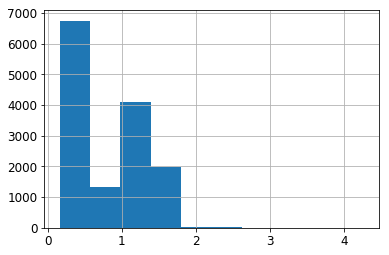

In [16]:
df.loc[df['fwhm_or_rhalf'] < 5.,'fwhm_or_rhalf'].hist()

In [17]:
df= df[df['fwhm_or_rhalf'] < 5.]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11900f940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119399518>]], dtype=object)

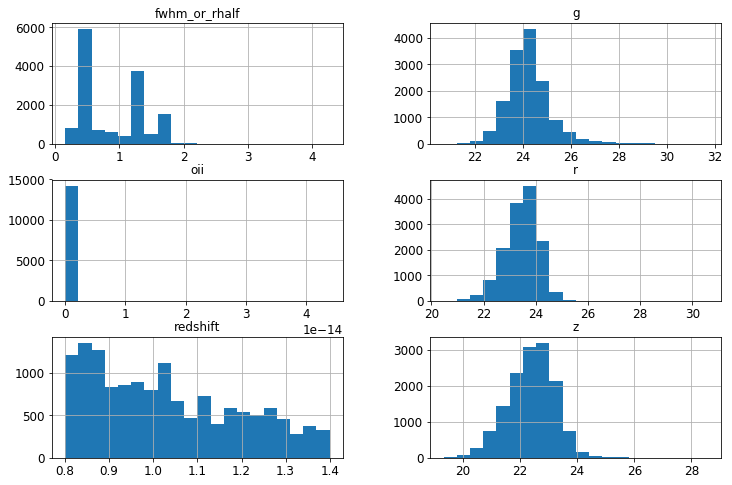

In [18]:
df.hist(bins=20,figsize=(12,8))

(array([  2.00000000e+00,   8.00000000e+00,   2.20000000e+01,
          6.00000000e+01,   1.20500000e+03,   8.24500000e+03,
          4.53600000e+03,   1.48000000e+02,   2.00000000e+01,
          3.00000000e+00]),
 array([-19.99397087, -19.33029194, -18.66661301, -18.00293407,
        -17.33925514, -16.67557621, -16.01189728, -15.34821835,
        -14.68453941, -14.02086048, -13.35718155]),
 <a list of 10 Patch objects>)

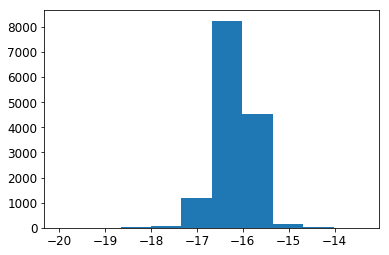

In [19]:
plt.hist(np.log10(df['oii']))

(-0.6, 2.2)

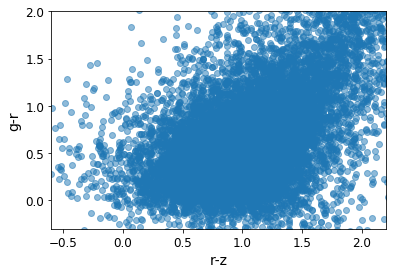

In [20]:
plt.scatter(df['r'] - df['z'],df['g'] - df['r'],alpha=0.5)
plt.xlabel('r-z')
plt.ylabel('g-r')
plt.ylim(-0.3,2)
plt.xlim(-0.6,2.2)

(-0.6, 2.2)

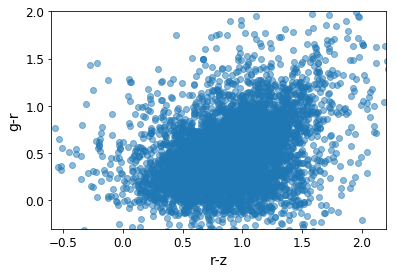

In [21]:
hiO2= df['oii'] > 8.e-17
plt.scatter((df['r'] - df['z'])[hiO2],(df['g'] - df['r'])[hiO2],alpha=0.5)
plt.xlabel('r-z')
plt.ylabel('g-r')
plt.ylim(-0.3,2)
plt.xlim(-0.6,2.2)

# DESI n(z): Sanchez & Kirby Mock

In [59]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
z_bins= np.loadtxt(os.path.join(DATA_DIR,'sanchez_kirkby_bins.txt'),
                   dtype=float)
pdf= np.loadtxt(os.path.join(DATA_DIR,'sanchez_kirkby_pdf.txt'),
                   dtype=float)
z_10k= fits_table(os.path.join(DATA_DIR,'sanchez_kirkby_z_rand10k.fits'))

In [32]:
z_bins,pdf

(array([ 0.37530702,  0.42530702,  0.47530702,  0.52530702,  0.57530702,
         0.62530702,  0.67530702,  0.72530702,  0.77530702,  0.82530702,
         0.87530702,  0.92530702,  0.97530702,  1.02530702,  1.07530702,
         1.12530702,  1.17530702,  1.22530702,  1.27530702,  1.32530702,
         1.37530702,  1.42530702,  1.47530702,  1.52530702,  1.57530702,
         1.62530702,  1.67530702,  1.72530702]),
 array([  5.97100000e-05,   1.50542000e-03,   1.76785300e-02,
          8.84732000e-02,   2.84925680e-01,   7.39386710e-01,
          1.34832717e+00,   1.67066185e+00,   1.67005896e+00,
          1.63804793e+00,   1.64072498e+00,   1.54290155e+00,
          1.34524606e+00,   1.19831291e+00,   1.13670714e+00,
          1.10855340e+00,   1.05699101e+00,   8.94507910e-01,
          6.31820920e-01,   4.59504660e-01,   3.94339850e-01,
          3.49333740e-01,   2.94378110e-01,   2.25234390e-01,
          1.48763210e-01,   8.26350600e-02,   3.09199400e-02]))

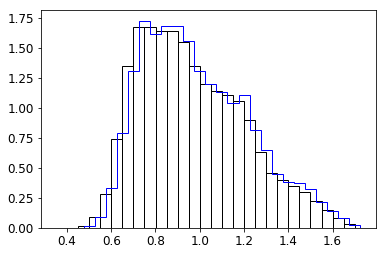

In [62]:
plt.bar(left=z_bins[:-1],height=pdf,width=z_bins[1]-z_bins[0],fill=False)
_=plt.hist(z_10k.z_cosmo,bins=z_bins,histtype='step',color='b',normed=True)


In [43]:
np.vstack([(z_bins[1:]+z_bins[:-1])/2,
           pdf]).T.shape

(27, 2)

In [48]:
mixture.GaussianMixture?

In [51]:
from sklearn.mixture import GMM


In [64]:
z_10k.z_cosmo.reshape(-1,1).shape

(10000, 1)

(1000, 1)


/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kaylan1/miniconda3/envs/mlbo

(array([   3.,    9.,   33.,   84.,  206.,  281.,  148.,   94.,  114.,   28.]),
 array([-5.58064657, -4.55094874, -3.52125091, -2.49155308, -1.46185526,
        -0.43215743,  0.5975404 ,  1.62723823,  2.65693606,  3.68663389,
         4.71633172]),
 <a list of 10 Patch objects>)

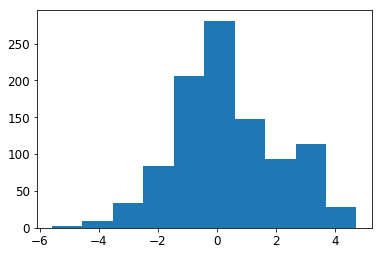

In [57]:
np.random.seed(1)

gmm = GMM(3, n_iter=1)
gmm.means_ = np.array([[-1], [0], [3]])
gmm.covars_ = np.array([[1.5], [1], [0.5]]) ** 2
gmm.weights_ = np.array([0.3, 0.5, 0.2])

X = gmm.sample(1000)
print(X.shape)
plt.hist(X)

In [58]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

In [67]:
X= z_10k.z_cosmo.reshape(-1,1)

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]




for i in range(len(N)):
    # Fit a Gaussian mixture with EM
    GMM = mixture.GaussianMixture(n_components=in_components,
                                  covariance_type=cv_type)
    GMM.fit(X)
    bic.append(GMM.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
    
    models[i] = GMM(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(5, 1.7))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob, responsibilities = M_best.eval(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)

ValueError: Invalid value for 'n_components': 0 Estimation requires at least one component

In [75]:
norm?

(10000, 1)
Y_.shape (10000,)
z_bins.shape= (28,)
(1, 28)
z_bins.shape= (28,)
(1, 28)
z_bins.shape= (28,)
(1, 28)
z_bins.shape= (28,)
(1, 28)


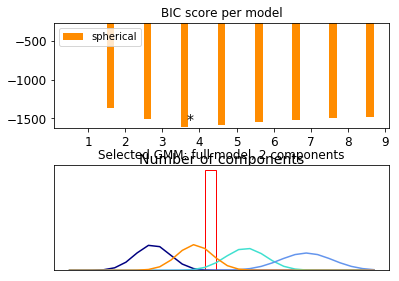

In [80]:
import itertools

from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

# Generate random sample, two components
X= z_10k.z_cosmo.reshape(-1,1)
print(X.shape)

lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
#cv_types = ['spherical', 'tied', 'diag', 'full']
#for cv_type in cv_types:
for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components)#
                                  #covariance_type=cv_type)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
#for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
i=0
xpos = np.array(n_components_range) + .2 * (i - 2)
bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                              (i + 1) * len(n_components_range)],
                    width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
print('Y_.shape',Y_.shape)
xpts= z_bins
from scipy.stats import norm
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    print('z_bins.shape=',z_bins.shape)
    print(norm(loc=mean,scale=cov**0.5).pdf(z_bins).shape)
    plt.plot(z_bins,norm(loc=mean,scale=cov**0.5).pdf(z_bins).T,c=color)
_=plt.hist(Y_,bins=z_bins,histtype='step',color='r',normed=True)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [84]:
X.shape,z_bins.shape

((10000, 1), (28,))

In [92]:
a=[norm(loc=mean,scale=cov**0.5).pdf(z_bins)[0,:] for mean,cov in zip(clf.means_, clf.covariances_)]

In [94]:
np.array(a).sum(axis=0)

array([  7.30882522e-05,   1.22773736e-03,   1.36793415e-02,
         1.01097631e-01,   4.95677438e-01,   1.61342361e+00,
         3.49799612e+00,   5.12772895e+00,   5.41401421e+00,
         5.01707358e+00,   5.23964438e+00,   5.60810414e+00,
         4.99138315e+00,   3.98299440e+00,   3.86493006e+00,
         4.48064214e+00,   4.69993684e+00,   4.11913548e+00,
         3.38776221e+00,   3.16633666e+00,   3.38037993e+00,
         3.49762197e+00,   3.14685868e+00,   2.37578924e+00,
         1.49225281e+00,   7.78449137e-01,   3.37162935e-01,
         1.21241389e-01])

Y_.shape (28,)
z_bins.shape= (28,)
(1, 28)
z_bins.shape= (28,)
(1, 28)
z_bins.shape= (28,)
(1, 28)
z_bins.shape= (28,)
(1, 28)


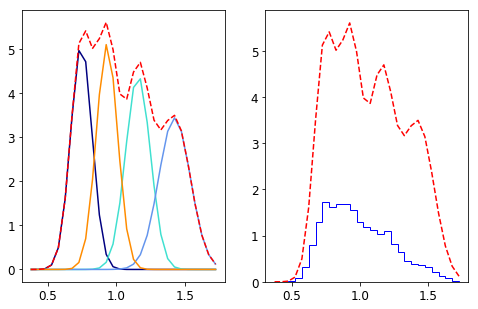

In [101]:
def gmm_sum(x, means,cov):
    return (np.array([norm(loc=mean,scale=cov**0.5).pdf(z_bins)[0,:] 
                      for mean,cov in zip(clf.means_, clf.covariances_)])
            .sum(axis=0))

fig,ax= plt.subplots(1,2,figsize=(8,5))

Y_ = clf.predict(z_bins.reshape(-1,1))
print('Y_.shape',Y_.shape)
xpts= z_bins
from scipy.stats import norm
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    print('z_bins.shape=',z_bins.shape)
    print(norm(loc=mean,scale=cov**0.5).pdf(z_bins).shape)
    ax[0].plot(z_bins,norm(loc=mean,scale=cov**0.5).pdf(z_bins).T,c=color)
ax[0].plot(z_bins,gmm_sum(z_bins, clf.means_,clf.covariances_),'r--')
#plt.plot(z_bins,Y_,'r--')

ax[1].plot(z_bins,gmm_sum(z_bins, clf.means_,clf.covariances_),'r--')
_=ax[1].hist(z_10k.z_cosmo,bins=z_bins,histtype='step',color='b',normed=True)

In [73]:
linalg.eigh(clf.covariances_[0])

(array([ 0.00608931]), array([[ 1.]]))

(array([ 1060.,   878.,   738.,   811.,   508.,   503.,   541.,   508.,
          348.,   361.]),
 array([ 0.80016702,  0.86012283,  0.92007864,  0.98003444,  1.03999025,
         1.09994605,  1.15990186,  1.21985766,  1.27981347,  1.33976927,
         1.39972508]),
 <a list of 10 Patch objects>)

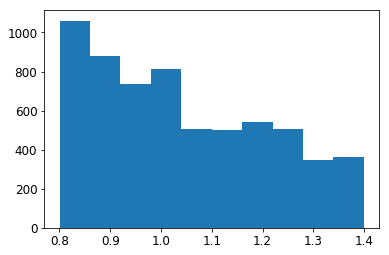

In [142]:
hiO2= df['oii'] > 8.e-17
plt.hist(df.loc[hiO2,'redshift'])

In [143]:
# Table 2.3 DESI Science Part 1
dN_dz_ddeg= np.array([309,2269,1923,2094,1441,1353,1337,523,466,329,126,0,0])
z= np.linspace(0.65,1.85,num=len(dN_dz_ddeg))
bin_width= z[1]-z[0]
zbins= np.linspace(z[0]-bin_width/2.,z[-1]+bin_width/2,num=len(z)+1)
len(dN_dz_ddeg),len(z),z,zbins

(13, 13, array([ 0.65,  0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,
         1.55,  1.65,  1.75,  1.85]), array([ 0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,
         1.7,  1.8,  1.9]))

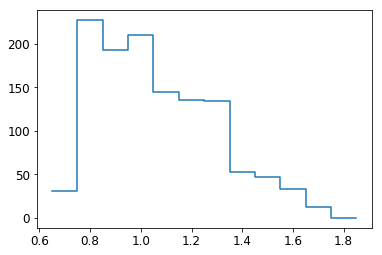

In [144]:
plt.step(z,dN_dz_ddeg/10,where='post')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,
         1.7,  1.8,  1.9]),
 <a list of 1 Patch objects>)

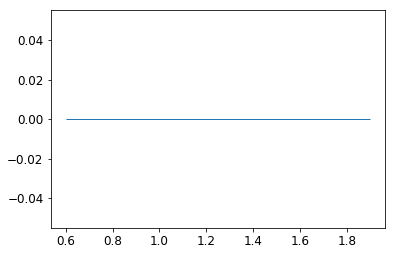

In [116]:
plt.hist(dN_dz_ddeg,bins=zbins,histtype='step')

In [117]:
plt.step?